<a href="https://colab.research.google.com/github/vishwvir-singh/swot-analysis/blob/master/SWOT_analysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import json

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep_Learning/SWOT_analysis/data

with open('swot_analysis_data.json') as f:
  data = json.load(f)

In [7]:
data[0]

{'description': "Lawsuits could result in huge penalties and affect the company's reputation. In December, 2018, Kove IO, Inc, a US-based storage appliances provider, filed a patent infringement lawsuit against Amazon Web Services (AWS) in the US District Court for the Northern District of Illinois. In its lawsuit, Kove alleged that AWS used its technology as a basic unit of its cloud business. Kove further said that it patented technology that allowed hyperscalable distributed cloud storage much before the development of the cloud.",
 'type': 'weaknesses',
 'word_count': 81}

In [8]:
def get_texts_labels(data):
  texts, labels = [], []
  lable_mapping = {
      "weaknesses": 0,
      "opportunities" :1,
      "strengths": 2,
      "threats": 3
  }
  for e in data:
    if e["word_count"] < 150:
      texts.append(e['description'])
      labels.append(lable_mapping[e['type']])
  return texts, labels

In [9]:
texts, labels = get_texts_labels(data)
print(len(texts))

39144


In [10]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, 
    labels, 
    test_size=.1, 
    random_state=42,
    shuffle=True)

_data = {
    'texts' : train_texts,
    'labels' : train_labels
    }

train_pd = pd.DataFrame.from_dict(_data)

train_pd['labels'].value_counts()

2    12219
1     9704
3     8096
0     5210
Name: labels, dtype: int64

In [11]:
from transformers import BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def get_max_len(train_texts, train_labels):
  _train_texts, _train_labels, = [], []
  max_len = 0
  bert_max_len = 512
  for id, sent in enumerate(train_texts):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    if len(input_ids) < bert_max_len:
      _train_texts.append(sent)
      _train_labels.append(train_labels[id])
  print('max_len :', max_len)
  print('train_len :', len(_train_texts))
  return max_len

In [ ]:
max_len = get_max_len(texts, labels)
max_len = max_len + 10
print('max_len :' , max_len)

max_len : 311
train_len : 39144
max_len : 321


In [13]:
# max_len = 3000
def tokenize_dataset(texts, labels, tokenizer, max_len):
  input_ids, attention_mask_ids, token_type_ids = [], [], []
  for text in texts:
    encoded_text = tokenizer.encode_plus(text, 
                        add_special_tokens = True,
                        max_length = max_len,
                        padding='max_length',
                        return_attention_mask = True,
                        return_token_type_ids=True,
                        truncation = True)

    input_ids.append(encoded_text['input_ids'])
    attention_mask_ids.append(encoded_text['attention_mask'])
    token_type_ids.append(encoded_text['token_type_ids'])

  return np.array(input_ids), np.array(attention_mask_ids), np.array(token_type_ids)

train_dataset = tokenize_dataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = tokenize_dataset(test_texts, test_labels, tokenizer, max_len)

In [17]:
from transformers import TFBertModel, BertConfig

In [18]:
from transformers import TFBertModel, BertConfig
n_classes = 4
# config = BertConfig(num_labels= n_classes, dropout=0.2, attention_dropout=0.2)
config = BertConfig(num_labels= n_classes)
# config.output_hidden_states = False
transformer_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)

input_ids_in = tf.keras.layers.Input(shape=(max_len,), name="input_ids", dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_len,), name="attention_mask_ids", dtype='int32') 
input_token_in = tf.keras.layers.Input(shape=(max_len,), name="token_type_ids", dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in, token_type_ids= input_token_in,)[0]

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer[:, 0, :])
# x = tf.keras.layers.GlobalMaxPool1D()(x)
# x = tf.keras.layers.Dense(50, kernel_initializer='he_uniform', activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# cls_token = embedding_layer[:,0,:]
# x = tf.keras.layers.BatchNormalization()(cls_token)
# x = tf.keras.layers.Dense(192, kernel_initializer='he_uniform', activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(embedding_layer[:, 0, :])
x = tf.keras.layers.Dense(256, activation='relu')(embedding_layer[:, 0, :])
x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

# X = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)
X = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, input_token_in], outputs = X)

# for layer in model.layers[:3]:
#   layer.trainable = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(
    lr = 8e-5
  )
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.keras.losses.categorical_crossentropy(from_logits=True)
model.compile(
    loss="sparse_categorical_crossentropy",
    # loss = loss,
    optimizer= optimizer,
    # metrics=["accuracy"]
    metrics=["sparse_categorical_accuracy"])

In [20]:
history = model.fit(
    # train_dataset,
    {
        "input_ids": train_dataset[0],
        "attention_mask_ids": train_dataset[1],
        "token_type_ids": train_dataset[2]
    },
    np.array(train_labels),
    epochs = 2,
    batch_size = 16)
    # validation_split = 0.2)

Epoch 1/4
2202/2202 [==============================] - 2561s 1s/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9131
Epoch 2/4
2202/2202 [==============================] - 2572s 1s/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9457
Epoch 3/4
2202/2202 [==============================] - 2573s 1s/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9566
Epoch 4/4
2202/2202 [==============================] - 2572s 1s/step - loss: 0.1203 - sparse_categorical_accuracy: 0.9636


In [ ]:
model.save("SWOT_analysis_BERT_accuracy_0-96_loss_0-1203")

In [22]:
history.history

{'loss': [0.27386799454689026,
  0.17372527718544006,
  0.14256775379180908,
  0.12030842900276184],
 'sparse_categorical_accuracy': [0.9131397604942322,
  0.9456697702407837,
  0.9565698504447937,
  0.9635811448097229]}

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


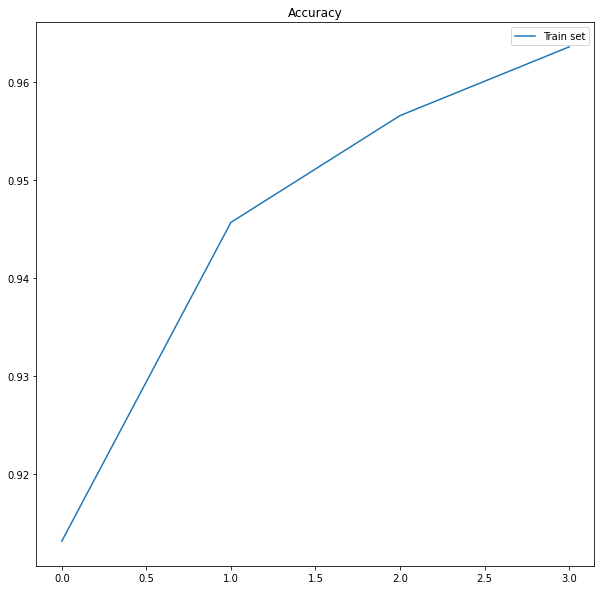

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import pandas as pd
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['sparse_categorical_accuracy']))
plt.plot(xaxis, history.history['sparse_categorical_accuracy'], label='Train set')
# plt.plot(xaxis, history.history['val_sparse_categorical_accuracy'], label='Validation set')
plt.legend()

In [ ]:
def predict(model, test_dataset, test_labels):
    y_pred = model.predict(test_dataset)
    y_pred = [np.argmax(i) for i in model.predict(test_dataset)]

    con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                            index=label_names, 
                            columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Text(0.5, 69.0, 'Predicted label')

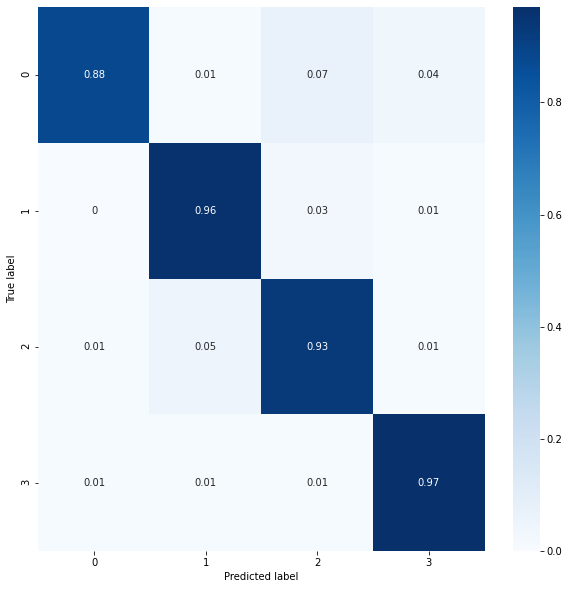

In [24]:
predict(model, test_dataset, test_labels)

In [ ]:
#LOAD SAVED MODEL and TEST 

In [ ]:
saved_model = tf.keras.models.load_model('SWOT_analysis_BERT_accuracy_0-96_loss_0-1203')

In [ ]:
predict(model, test_dataset, test_labels)